In [1]:
########## Imports ##########
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

import packages.fonctions as fonctions
from packages import cost

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer

# Modèles
#!pip install catboost
#!brew install cmake libomp
#!pip install lightgbm
from sklearn.dummy import DummyClassifier # modèle baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier # A UTILISER
import xgboost as xgb

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# MLFLOW
import mlflow
from mlflow.models import infer_signature
import logging

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 200)

In [2]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, 'data/df_train')

with open(filepath, 'rb') as f:
    df = pickle.load(f)

df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,PREV_APPL_MEAN_CARD_MEAN_SK_DPD,PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION,PREV_

In [3]:
filepath = os.path.join(path, 'data/target')

with open(filepath, 'rb') as f:
    df_target = pickle.load(f)

df_target.head()

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
Name: TARGET, dtype: int64

In [4]:
# Séparation en train et en test

X = df
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
# on remet la target dans les données ?
#X_train['TARGET'] = y_train
#X_test['TARGET'] = y_test

In [6]:
print('train shape :', X_train.shape)
print('test shape :', X_test.shape)

train shape : (232842, 175)
test shape : (58211, 175)


In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((232842, 175), (58211, 175), (232842,), (58211,))

In [8]:
# ici :
# -> données avec labels -> Supervised Learning
# -> 0/1 (variable discrète) -> Classification

In [9]:
# ML FLOW

# -> partie à comprendre

"""

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri = "http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model = lr,
        artifact_path = "iris_model",
        signature = signature,
        input_example = X_train,
        registered_model_name = "tracking-quickstart",
    )

    """




#logging.basicConfig(level = logging.WARN)
#logger = logging.getLogger(__name__)

mlflow.set_tracking_uri(uri = "http://127.0.0.1:8080")
#mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name = 'scoring')

<Experiment: artifact_location='mlflow-artifacts:/758371766557830604', creation_time=1714046714905, experiment_id='758371766557830604', last_update_time=1714046714905, lifecycle_stage='active', name='scoring', tags={}>

### Fonction de coût

In [10]:
######### Analyse des erreurs de prédiction ########

# - FP (False Positive) :
# = quand la prédiction est positive, mais la valeur réelle est négative
# va induire une perte réelle si le crédit client accepté se transforme en défaut de paiement. -> PENALITE DE 10

# - FN (False Negative) :
# = quand la prédiction est négative, mais la valeur réelle est positive
# va induire une perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé. -> PENALITE DE 1

# les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.

# L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN.
# On part du F-Score, mesure de la performance d'un modèle de classification qui combine les mesures de précision et de rappel, elles mêmes basées sur les taux de vrais positifs, faux positifs et faux négatifs
# (donc va être idéal à adapter dans notre cas)

# cf cost.py

### Regression logistique

In [11]:
### Logistic Regression

# Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc…
# La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit.
# Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [12]:
# Régression Logistique
lr = LogisticRegression()
lr.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7433
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     53329
           1       0.53      0.01      0.03      4882

    accuracy                           0.92     58211
   macro avg       0.72      0.51      0.49     58211
weighted avg       0.88      0.92      0.88     58211



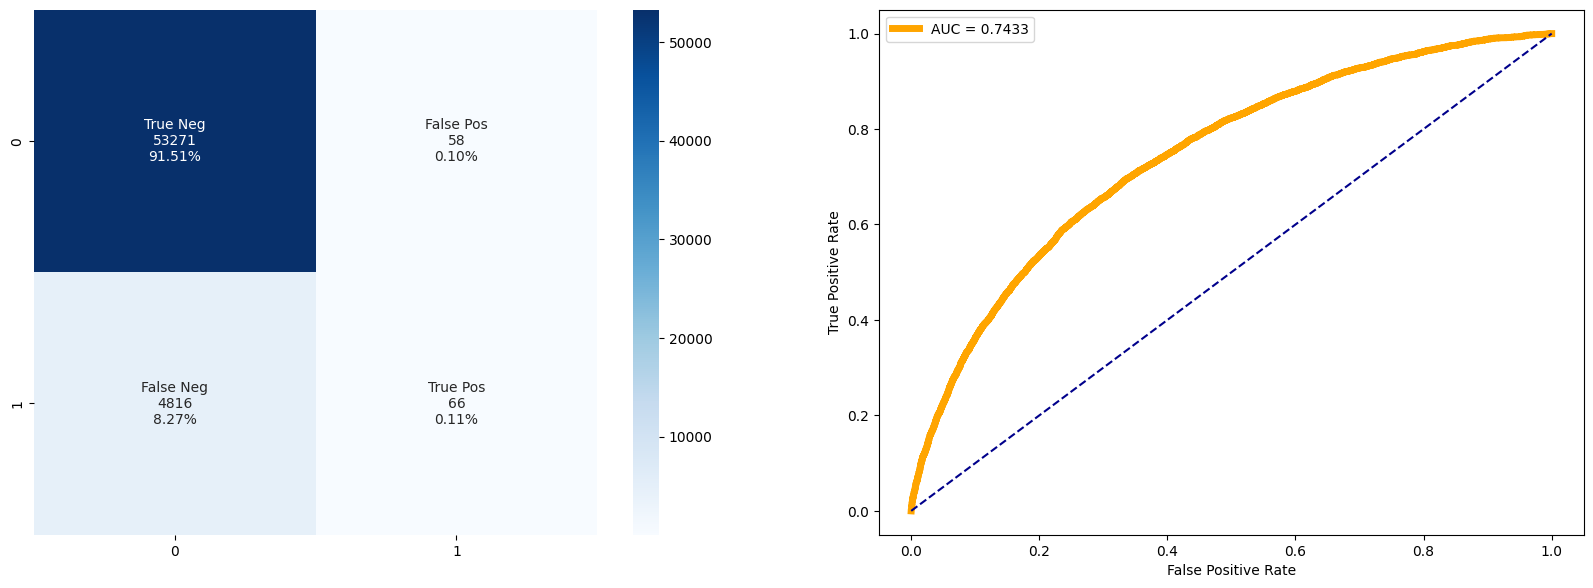

In [13]:
fonctions.cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], roc_auc)

In [14]:
cost.custom_metric(y_test, lr.predict(X_test))

5103

In [15]:
# AUC = Area Under the Curve ROC
# courbe ROC : Recall in y-axis and 1-Specificity in x-axis

# -> indicates how well the probabilities from the positive classes are separated from the negative classes
# 0,5 -> 50%/50% -> le marqueur est non informatif
# entre 0,5 et 1,0 -> discrimination

In [16]:
####### mhhhhhhhhhh
# surement un problème lié au déséquilibre des classes

# 2 options :
# - undersampling : Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires
# - oversampling : Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation

# pour l'oversampling : différentes solutions sont possibles, comme le “clonage” aléatoire ou le SMOTE

In [17]:
# SMOTE
# = Synthetic Minority Oversampling TEchnique
# = méthode de suréchantillonnage des observations minoritaires

# https://kobia.fr/imbalanced-data-smote/

In [18]:
# https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn

In [19]:
# Définition de l'instance SMOTE
sm = SMOTE(
    k_neighbors = 3, # nombre de plus proches voisins
    sampling_strategy = 0.75, # taux d'observatios minoritaires à atteindre
    random_state = 0
    )

# Application du SMOTE aux données
X_smote, y_smote = sm.fit_resample(X, y)

In [20]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 0)

In [21]:
# SMOTE -> tuner hyperparamètres

In [22]:
# on remet la target dans les données ?
#X_train_smote['TARGET'] = y_train_smote
#X_test_smote['TARGET'] = y_test_smote

In [23]:
# Régression Logistique
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)

roc_auc = roc_auc_score(y_test_smote, lr.predict_proba(X_test_smote)[:, 1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test_smote, lr.predict(X_test_smote)))

AUC : 0.7621
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     53701
           1       0.67      0.58      0.62     39822

    accuracy                           0.70     93523
   macro avg       0.69      0.68      0.69     93523
weighted avg       0.70      0.70      0.69     93523



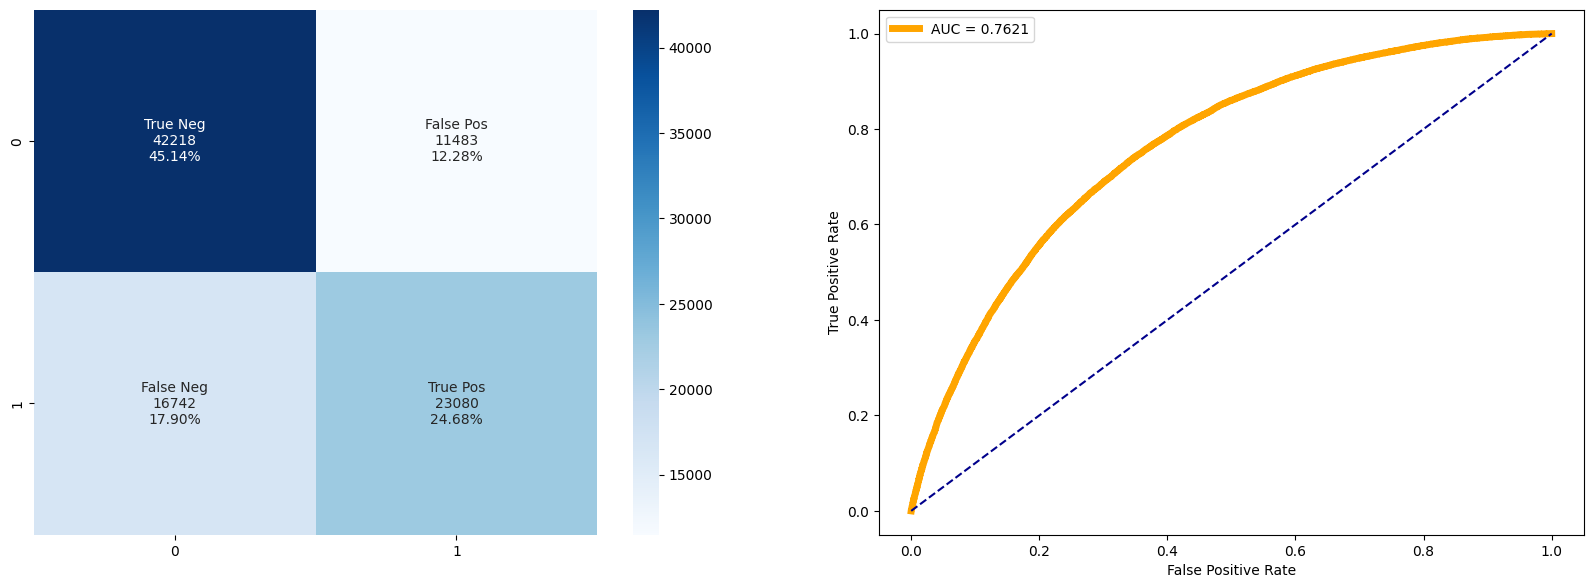

In [24]:
fonctions.cf_matrix_roc_auc(lr, y_test_smote, lr.predict(X_test_smote), lr.predict_proba(X_test_smote)[:, 1], roc_auc)

In [25]:
cost.custom_metric(y_test_smote, lr.predict(X_test_smote))

-136799

In [26]:
# mhhhhhhh

### Test de différents modèles

In [27]:
# Modèles à tester

"""
models = [
          CatBoostClassifier(task_type = 'GPU', logging_level = 'Silent'),
          LGBMClassifier(device = 'gpu'),
          XGBClassifier(tree_method = 'gpu_hist', predictor = 'gpu_predictor')
          ]"""

"\nmodels = [\n          CatBoostClassifier(task_type = 'GPU', logging_level = 'Silent'),\n          LGBMClassifier(device = 'gpu'),\n          XGBClassifier(tree_method = 'gpu_hist', predictor = 'gpu_predictor')\n          ]"

In [28]:
# modèle baseline
# prets attribués de manière aléatoire
# dummy classifier

In [29]:
# ne pas oublier de sauvegarder à chaque fois les résultats dans mlflow
# si je le fais une fois pour toute ça va aussi

In [30]:
models = [
    DummyClassifier(), # modèle baseline
    KNeighborsClassifier(), # k-nearest neighbors
    LogisticRegression(), # Regression logistique
    GaussianNB(), # Naives Bayes
    #SVC(), # -> long !! # Support Vector Machines - beaucoup trop long, exclu d'office
    CatBoostClassifier(logging_level = 'Silent'),
    LGBMClassifier(),
    DecisionTreeClassifier(), # Arbres de decision
    RandomForestClassifier(), # random forest
    AdaBoostClassifier(),
    GradientBoostingClassifier(), # gradient boosting
    xgb.XGBClassifier() # XGBoost
    #XGBClassifier() # -> erreur !
    ]

In [31]:
# Fonction pour calculer les métriques auc, accuracy, f1, precision et recall

def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'Custom' : cost.custom_metric(y_test, model.predict(X_test))
      }

    return output

In [32]:
# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 18963, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27344
[LightGBM] [Info] Number of data points in the train set: 232842, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081441 -> initscore=-2.422921
[LightGBM] [Info] Start training from score -2.422921
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [33]:
# même chose mais avec mlflow

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []


with mlflow.start_run(run_name = 'Test modèles'):
    for model in models:
        print(type(model).__name__)
        start = time.time()
        results = train_models(model, X_train, X_test, y_train, y_test)

        name.append(type(model).__name__)
        auc.append(results['AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        custom.append(results['Custom'])
        time_.append(time.time() - start)

        mlflow.sklearn.log_model(model, 'model')
        mlflow.log_metric('f1 score', results['F1'])
        mlflow.log_metric('custom', results['Custom'])

# Initialise data of lists
base_models = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models.sort_values('AUC', ascending = False, inplace = True)
base_models.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 18963, number of negative: 213879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27344
[LightGBM] [Info] Number of data points in the train set: 232842, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081441 -> initscore=-2.422921
[LightGBM] [Info] Start training from score -2.422921
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [34]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
0,CatBoostClassifier,0.768282,0.91603,0.491713,0.03646,0.067887,6111,31.531561
1,LGBMClassifier,0.763242,0.916356,0.532995,0.021508,0.041347,5454,3.077329
2,XGBClassifier,0.760697,0.915531,0.461707,0.04322,0.079041,6408,33.265844
3,GradientBoostingClassifier,0.754175,0.916201,0.514493,0.014543,0.028287,5148,292.007617
4,AdaBoostClassifier,0.744402,0.916236,0.515306,0.020688,0.039779,5418,56.296697
5,LogisticRegression,0.743299,0.91627,0.532258,0.013519,0.026368,5103,4.865532
6,RandomForestClassifier,0.704279,0.916098,0.4375,0.001434,0.002858,4572,144.234396
7,GaussianNB,0.643198,0.17349,0.087783,0.942851,0.160613,45936,0.534486
8,KNeighborsClassifier,0.584948,0.910429,0.239812,0.03134,0.055435,5886,179.33455
9,DecisionTreeClassifier,0.537975,0.848139,0.144831,0.165301,0.154391,11772,33.184876


In [35]:
base_models.sort_values('Custom', ascending = False)

,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
7,GaussianNB,0.643198,0.17349,0.087783,0.942851,0.160613,45936,0.534486
9,DecisionTreeClassifier,0.537975,0.848139,0.144831,0.165301,0.154391,11772,33.184876
2,XGBClassifier,0.760697,0.915531,0.461707,0.04322,0.079041,6408,33.265844
0,CatBoostClassifier,0.768282,0.91603,0.491713,0.03646,0.067887,6111,31.531561
8,KNeighborsClassifier,0.584948,0.910429,0.239812,0.03134,0.055435,5886,179.33455
1,LGBMClassifier,0.763242,0.916356,0.532995,0.021508,0.041347,5454,3.077329
4,AdaBoostClassifier,0.744402,0.916236,0.515306,0.020688,0.039779,5418,56.296697
3,GradientBoostingClassifier,0.754175,0.916201,0.514493,0.014543,0.028287,5148,292.007617
5,LogisticRegression,0.743299,0.91627,0.532258,0.013519,0.026368,5103,4.865532
6,RandomForestClassifier,0.704279,0.916098,0.4375,0.001434,0.002858,4572,144.234396


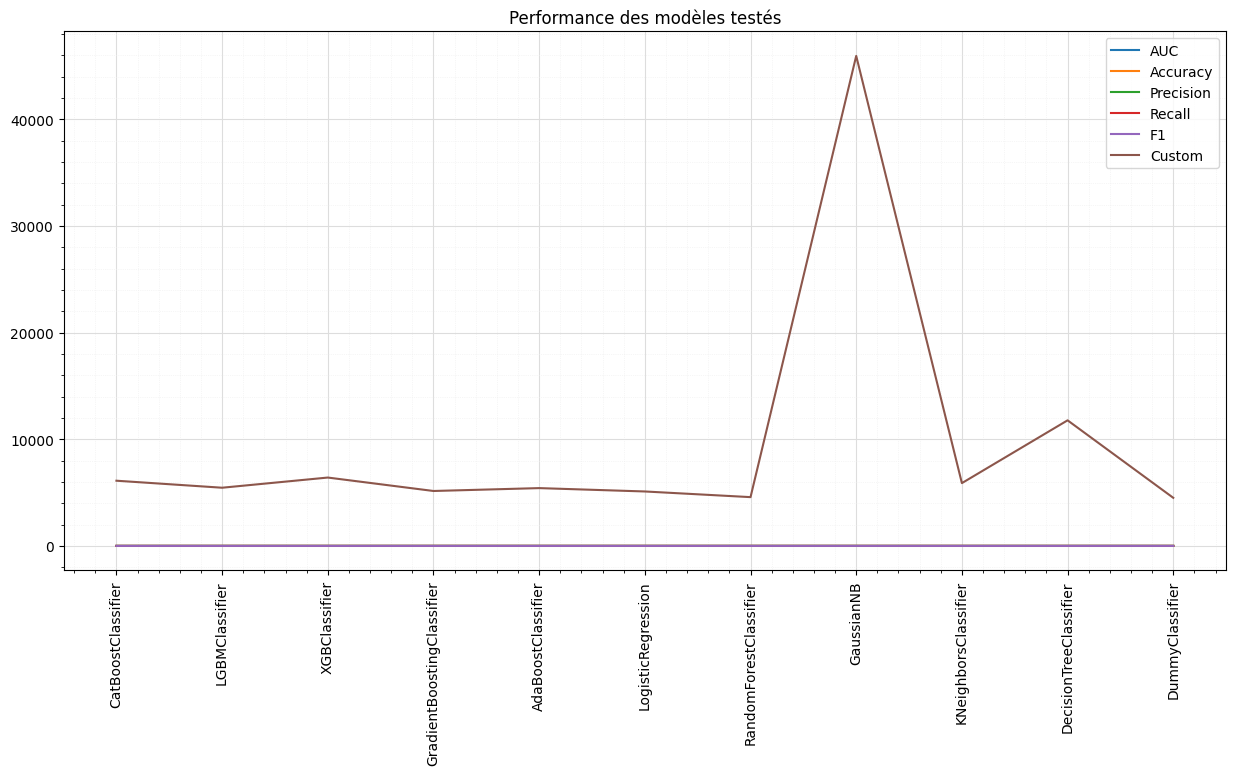

In [36]:
# plot results

plt.figure(figsize = (15, 7))
plt.title('Performance des modèles testés')
for i in base_models.drop(['Model', 'Time'], axis = 1).columns:
    plt.plot(base_models['Model'], base_models[i], label = i)
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

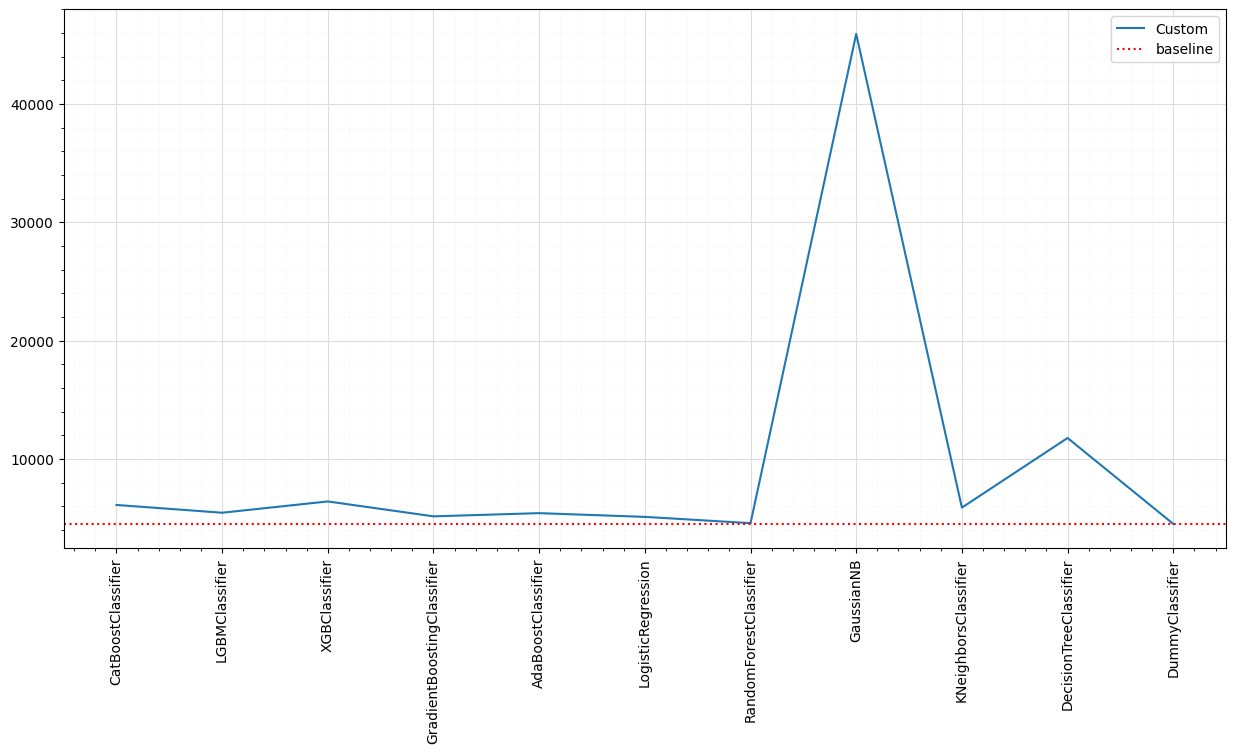

In [37]:
# plot results métrique custom only
base_models_custom = base_models[['Model', 'Custom']]

plt.figure(figsize = (15, 7))
for i in base_models_custom.drop(['Model'], axis = 1).columns:
    plt.plot(base_models_custom['Model'], base_models_custom[i], label = i)
plt.axhline(y = 4509, color = 'r', linestyle = ':', label = 'baseline')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

In [38]:
# essayer de trouver solution mais si je galère vraiment trop je laisse tomber
# comparer 3-5 modèles

In [39]:
# Idem mais avec SMOTE

X_smote, y_smote = sm.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 0)

# Boucler sur les modèles et évaluer

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
custom = []
time_ = []

for model in models:
    print(type(model).__name__)
    start = time.time()
    results = train_models(model, X_train_smote, X_test_smote, y_train_smote, y_test_smote)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    custom.append(results['Custom'])
    time_.append(time.time() - start)

# Initialise data of lists
base_models_smote = pd.DataFrame(data = [name, auc, accuracy, precision, recall, f1, custom, time_]).T
base_models_smote.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Custom', 'Time']
base_models_smote.sort_values('AUC', ascending = False, inplace = True)
base_models_smote.reset_index(drop = True, inplace = True)

DummyClassifier
KNeighborsClassifier
LogisticRegression
GaussianNB
CatBoostClassifier
LGBMClassifier
[LightGBM] [Info] Number of positive: 160584, number of negative: 213507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37463
[LightGBM] [Info] Number of data points in the train set: 374091, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429265 -> initscore=-0.284852
[LightGBM] [Info] Start training from score -0.284852
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


In [40]:
base_models_smote

,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
0,RandomForestClassifier,0.980411,0.948398,0.995161,0.883105,0.93579,-28016,215.455231
1,CatBoostClassifier,0.972689,0.948761,0.994188,0.884838,0.936331,-27395,67.412038
2,XGBClassifier,0.971295,0.948547,0.992433,0.885917,0.936155,-27008,68.429736
3,LGBMClassifier,0.970968,0.948152,0.997666,0.880292,0.935311,-29024,7.946629
4,GradientBoostingClassifier,0.962774,0.931792,0.996762,0.842549,0.913191,-42551,635.835475
5,AdaBoostClassifier,0.94496,0.896806,0.925867,0.82359,0.871739,-49346,121.600473
6,KNeighborsClassifier,0.941663,0.798199,0.679472,0.995831,0.807781,12385,583.902799
7,DecisionTreeClassifier,0.886942,0.887333,0.855876,0.88431,0.869861,-27584,39.685274
8,LogisticRegression,0.762132,0.698203,0.667766,0.579579,0.620555,-136799,8.934328
9,GaussianNB,0.588369,0.489516,0.452038,0.937246,0.609913,-8612,1.590271


In [41]:
base_models_smote.sort_values('Custom', ascending = False)

,Model,AUC,Accuracy,Precision,Recall,F1,Custom,Time
6,KNeighborsClassifier,0.941663,0.798199,0.679472,0.995831,0.807781,12385,583.902799
9,GaussianNB,0.588369,0.489516,0.452038,0.937246,0.609913,-8612,1.590271
2,XGBClassifier,0.971295,0.948547,0.992433,0.885917,0.936155,-27008,68.429736
1,CatBoostClassifier,0.972689,0.948761,0.994188,0.884838,0.936331,-27395,67.412038
7,DecisionTreeClassifier,0.886942,0.887333,0.855876,0.88431,0.869861,-27584,39.685274
0,RandomForestClassifier,0.980411,0.948398,0.995161,0.883105,0.93579,-28016,215.455231
3,LGBMClassifier,0.970968,0.948152,0.997666,0.880292,0.935311,-29024,7.946629
4,GradientBoostingClassifier,0.962774,0.931792,0.996762,0.842549,0.913191,-42551,635.835475
5,AdaBoostClassifier,0.94496,0.896806,0.925867,0.82359,0.871739,-49346,121.600473
8,LogisticRegression,0.762132,0.698203,0.667766,0.579579,0.620555,-136799,8.934328


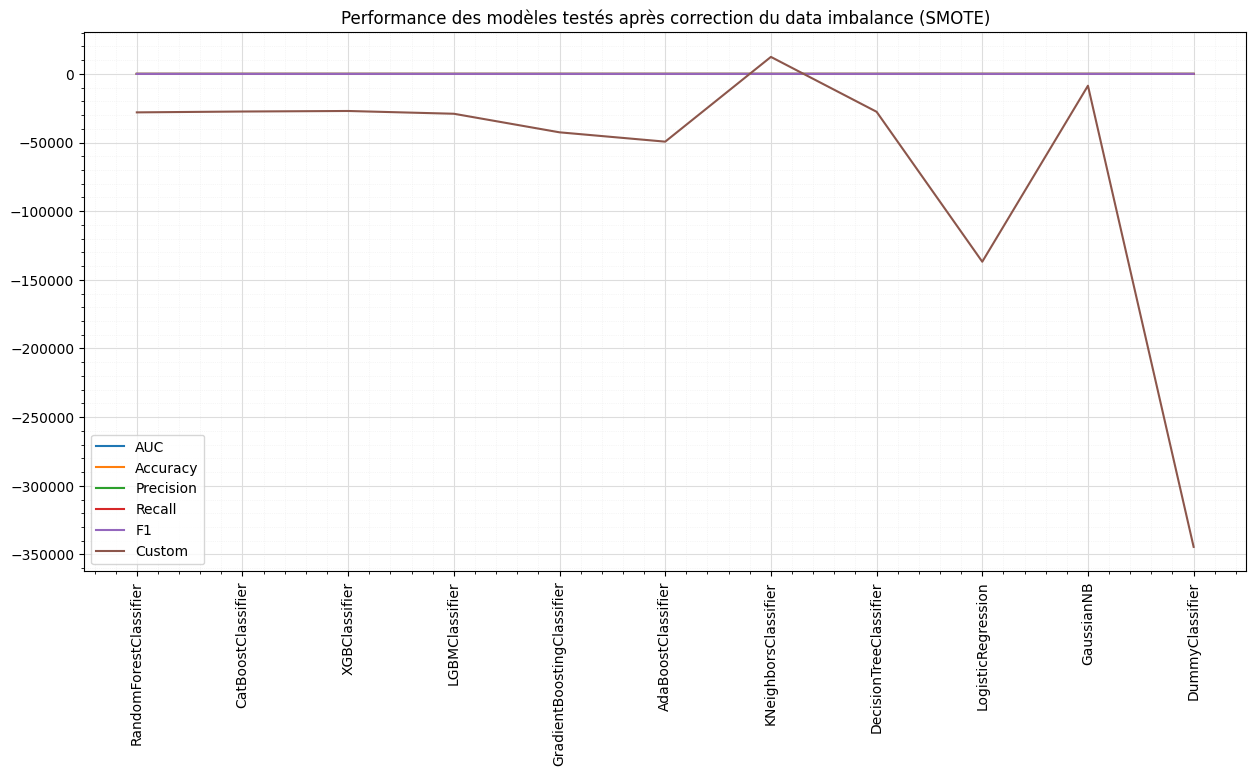

In [42]:
# plot results

plt.figure(figsize = (15, 7))
plt.title('Performance des modèles testés après correction du data imbalance (SMOTE)')
for i in base_models_smote.drop(['Model', 'Time'], axis = 1).columns:
    plt.plot(base_models_smote['Model'], base_models_smote[i], label = i)
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

In [43]:
# voir comment plotter graphs avec différentes échelles
# https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

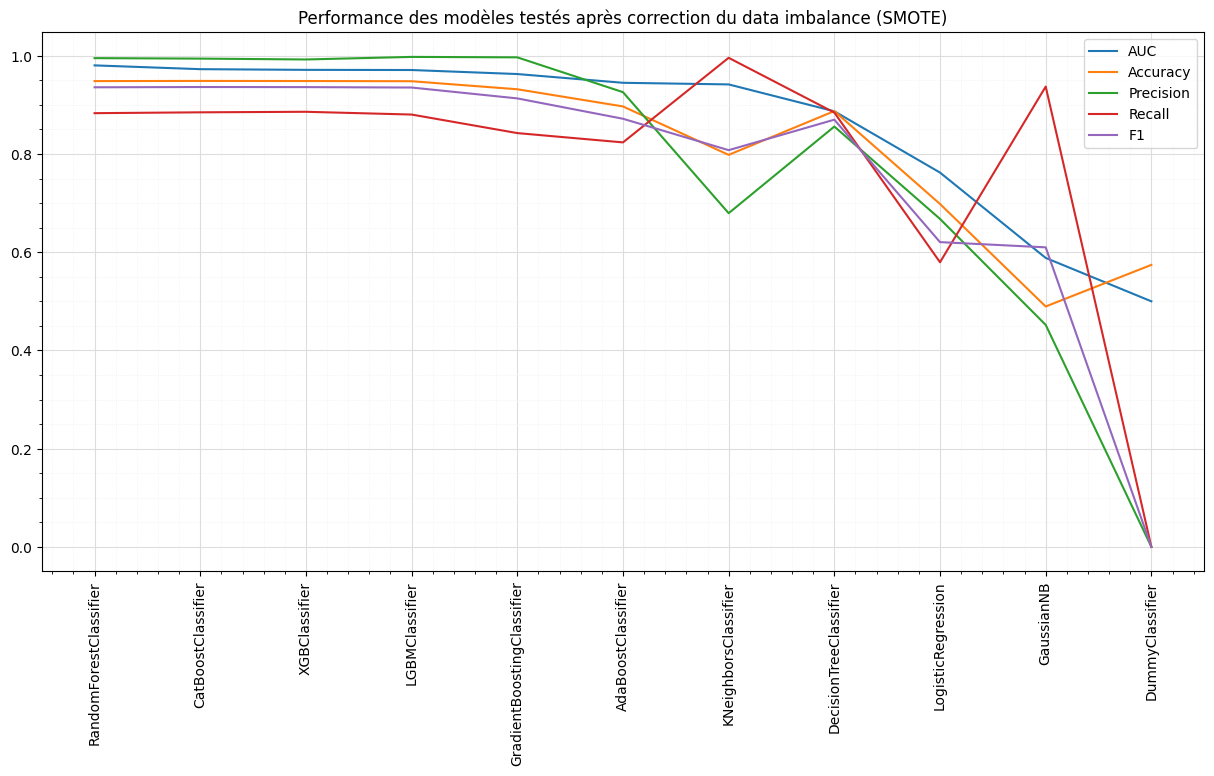

In [44]:
# plot results

plt.figure(figsize = (15, 7))
plt.title('Performance des modèles testés après correction du data imbalance (SMOTE)')
for i in base_models_smote.drop(['Model', 'Time', 'Custom'], axis = 1).columns:
    plt.plot(base_models_smote['Model'], base_models_smote[i], label = i)
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

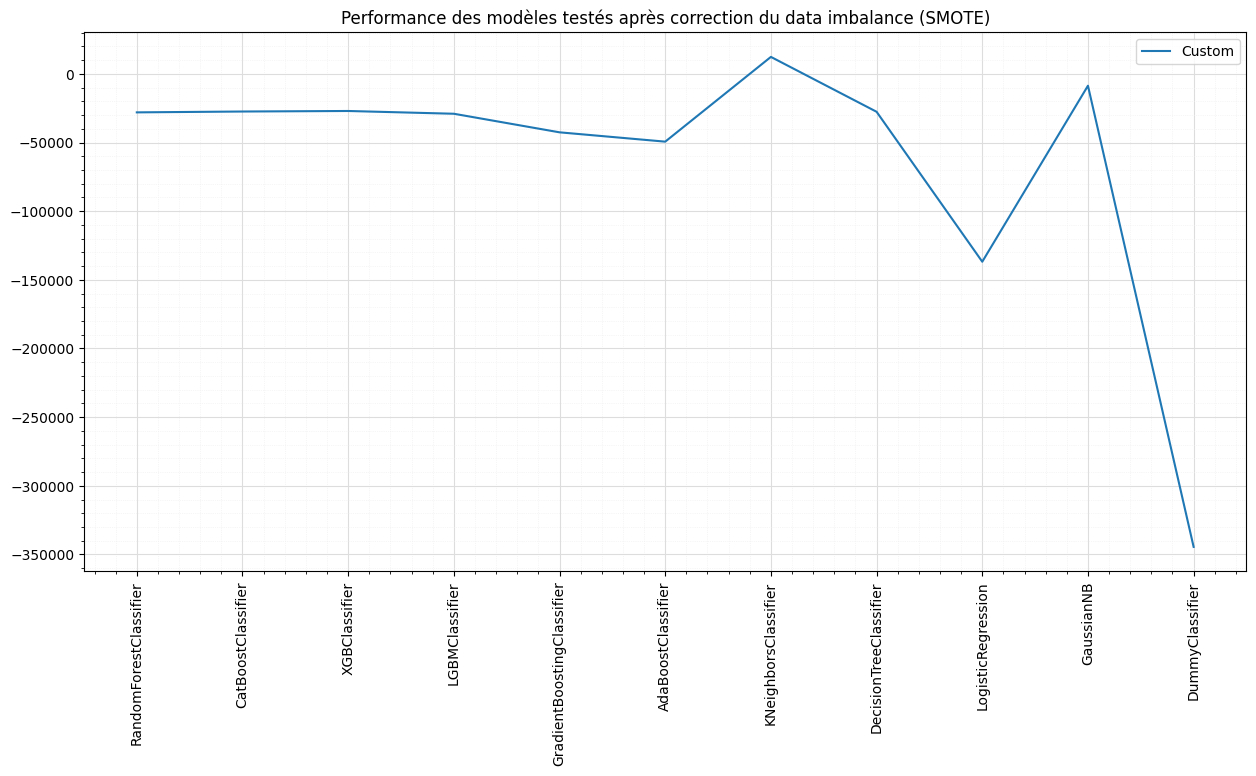

In [45]:
plt.figure(figsize = (15, 7))
plt.title('Performance des modèles testés après correction du data imbalance (SMOTE)')
plt.plot(base_models_smote['Model'], base_models_smote['Custom'], label = 'Custom')
plt.legend(loc = 'best')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.xticks(rotation = 90)
plt.show()

In [46]:
# Make scorer
# -> permet de définir dans quel "sens" prendre notre nouvelle métrique (ici, plus la valeur est grande, mieux c'est)
custom_score = make_scorer(cost.custom_metric, greater_is_better = True)
custom_score

make_scorer(custom_metric)

In [47]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# choisir un seul modèle et le fine tuner (eventuellement deux si j'ai un doute)
# choisir avec ou sans smote

In [ ]:
# modèle qui semble le plus approprié (temps vs perf) = 

In [ ]:
########## XGBoost Default Params ##########

# début de l'execution
start = time.time()

# Instancier le modèle
boost = GradientBoostingRegressor()

# Entrainer le modèle
boost.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Score
print(f'Coefficient de détermination (R2) = {boost.score(X_test, y_test)}')

# Predire
y_pred_test_default = boost.predict(X_test)
y_pred_train_default = boost.predict(X_train)

In [ ]:
# gridsearch

%%time

########## GRIDSEARCH CV ##########

# début de l'execution
start = time.time()
time_debut = datetime.now()
time_debut_convert = time_debut.strftime('%H:%M:%S')
print(f'Début : {time_debut_convert}\n')

param_grid = {'n_estimators': [25, 50, 100, 200, 500, 1000], # default = 100
              'max_depth': [None, 1, 2, 3, 4, 6, 10, 15, 20], # default = 3
              'min_samples_split': [2, 3, 4, 5], # default = 2
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], # default = 0.1
              'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'] # default = 'squared_error'
             }

grid = GridSearchCV(GradientBoostingRegressor(),
                    param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1
                   )

# On entraîne la grille 
grid.fit(X_train, y_train)

# fin de l'execution
end = time.time()
temps = end - start

# Meilleur score obtenu: best_score_
print(f'\nBest score = {grid.best_score_}')

# Optimal hyperparameters: best_params_
display(grid.best_params_) 

# Sauvegarder le meilleur modèle
best_boost = grid.best_estimator_

# Tester le meilleur modèle sur données test
print(f'Coefficient de détermination (R2) = {best_boost.score(X_test, y_test)}\n')

# Predire
y_pred_test_best = best_boost.predict(X_test)
y_pred_train_best = best_boost.predict(X_train)

In [ ]:
# Courbe d'apprentissage (learning curve)
# montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit

N, train_score, val_score = learning_curve(best_boost, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 10), cv = 5)

# Train sizes
print(f"Quantités de données à utiliser pour l'entrainement (10 lots): {N}")

# Learning curve
plt.figure(figsize = (7,5))
plt.grid()
plt.plot(N, train_score.mean(axis = 1), 'o-', color = 'r', label = 'Train')
plt.plot(N, val_score.mean(axis = 1), 'o-', color  = 'g', label = 'Validation')
plt.title ('Learning Curve', fontsize = 15, color = 'darkblue')
plt.legend(loc = 'best')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.show()

In [ ]:
# Plot prédictions

plt.figure(figsize = (25, 10))
plt.subplot(2, 2, 1)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_default, color = 'blue')
plt.title('train - default')
plt.subplot(2, 2, 2)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_default, color = 'green')
plt.title('test - default')
plt.subplot(2, 2, 3)
plt.plot(y_train.values, color = 'orange')
plt.plot(y_pred_train_best, color = 'blue')
plt.title('train - best params')
plt.subplot(2, 2, 4)
plt.plot(y_test.values, color = 'orange')
plt.plot(y_pred_test_best, color = 'green')
plt.title('test - best params')

plt.show()

In [ ]:
# Plot prédictions

plt.figure(figsize = (25, 10))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan = 3)
ax1.plot(y_train.values, color = 'orange', linestyle = '--', label = 'y_train')
ax1.plot(y_pred_train_default, color = 'blue', label = 'y_pred train (default)')
ax1.plot(y_pred_train_best, color = 'green', label = 'y_pred train (best)')
plt.legend(loc = "best")

ax2 = plt.subplot2grid((1, 5), (0, 3), colspan = 2)
ax2.plot(y_test.values, color = 'orange', linestyle = '--', label = 'y_test')
ax2.plot(y_pred_test_default, color = 'blue', label = 'y_pred test (default)')
ax2.plot(y_pred_test_best, color = 'green', label = 'y_pred test (best)')
plt.legend(loc = "best")

plt.show()

In [ ]:
# feature importance
# par exemple shap
# certains modèles comme random forest le font direct

In [ ]:
########## FEATURES IMPORTANTES ##########
# identifier les features importantes

# get importance
score = best_model.feature_importances_
feature = X.columns #(pour ne pas prendre l'index)

# transformer en df pour visualiser plus facilement
df_feature = pd.DataFrame()
df_feature['feature'] = feature
df_feature['score'] = score

df_feature.sort_values(['score'], ascending = False, inplace = True)

# bar plot pour visualiser les 25 features les plus importantes
plt.figure(figsize = (10, 7))
plt.title('Feature importances')
sns.barplot(x = df_feature['feature'].values[:25], y = df_feature['score'].values[:25])
plt.xticks(rotation = 90)
plt.show()